In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
from itertools import chain
import numpy as np
import glob

from sklearn.model_selection import cross_val_score, train_test_split

from shap import DeepExplainer
import shap
from torch import optim, nn
import torch
from torch.utils.data import DataLoader

In [2]:
EPOCHS = 100
DEVICE = "cuda"
BATCHSIZE = 32
TESTSIZE = 0.1

In [3]:
def get_data_from_dir(exp_dir):
    # get op, int format data from exp_dir
    exps = glob.glob(os.path.join(exp_dir, "*/"))
    chromos = []
    for e in exps:
        seed = e.split("/")[-2]
        with open(os.path.join(e, "outcomes.json"), "r") as f:
            results = json.load(f)
            for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
                c = list(chain.from_iterable(chromo[1]))
                c.append(seed)
                c.append(fitness[1])
                chromos.append(c)
    columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
    columns.append("seed")
    columns.append("test acc")
    columns
    df = pd.DataFrame(chromos, columns=columns)
    
    # create data in long format
    ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
    indexes = {op:i for i, op in enumerate(ops)}
    chromos_long = np.zeros([len(chromos), len(ops)+2])
    for i, c in enumerate(chromos):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-2] = int(c[-2])
            chromos_long[i][-1] = c[-1]
    columns_long = list(ops) + ["seed", "fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    return df, df_long, ops

def get_data(exp_path):
    chromos = []
    with open(exp_path, "r") as f:
        results = json.load(f)
        for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
            c = list(chain.from_iterable(chromo[1]))
            c.append(fitness[1])
            chromos.append(c)
    columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
    columns.append("test acc")
    columns
    df = pd.DataFrame(chromos, columns=columns)
    
    # create data in long format
    ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
    indexes = {op:i for i, op in enumerate(ops)}
    chromos_long = np.zeros([len(chromos), len(ops)+1])
    for i, c in enumerate(chromos):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-1] = c[-1]
    columns_long = list(ops) + ["fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    return df, df_long, ops

In [4]:
df, df_long, ops = get_data_from_dir(exp_dir="/home/noah/ESSL/cc_experiments/models_figs6/opt/exp6_0")
df_long
X = df_long.drop(columns = ["seed", "fitness"]).to_numpy(dtype="float32")
y = df_long["fitness"].to_numpy(dtype="float32")
y/=100

# create dataloaders
class Data(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):        
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)



In [5]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(X.shape[1], 32),
                                      nn.ReLU(),
                                      nn.Linear(32, 64),
                                      nn.ReLU(), 
                                      nn.Linear(64, 128),
                                      nn.ReLU(), 
                                      nn.Linear(128, 64),
                                      nn.ReLU(), 
                                      nn.Linear(64, 32),
                                      nn.ReLU(), 
                                      nn.Linear(32, 1),
                                      nn.Sigmoid()
                                     )
    def forward(self, X):
        return self.net(X)
                                      

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


epoch:  0
train loss:  0.10869626700878143
test loss:  0.9946520701050758
epoch:  1
train loss:  0.031176707269076037
test loss:  0.2769224578514695
epoch:  2
train loss:  0.012405105318654986
test loss:  0.1136851436458528
epoch:  3
train loss:  0.006279759889687686
test loss:  0.056409233482554555
epoch:  4
train loss:  0.002563567900591913
test loss:  0.023175903887022287
epoch:  5
train loss:  0.0012196409276357906
test loss:  0.011284661741228774
epoch:  6
train loss:  0.0006177903851494193
test loss:  0.005717405103496276
epoch:  7
train loss:  0.0003928041919339996
test loss:  0.00369640772260027
epoch:  8
train loss:  0.0002789588256478857
test loss:  0.0026158635519095697
epoch:  9
train loss:  0.00018613260309554308
test loss:  0.0017655296724115033
epoch:  10
train loss:  0.00017353891898357475
test loss:  0.001636859255086165
epoch:  11
train loss:  0.00016187972890774663
test loss:  0.001512668273790041
epoch:  12
train loss:  0.00013915726637659485
test loss:  0.001321982

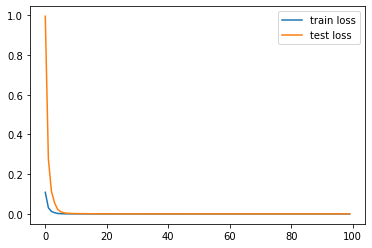

epoch:  0
train loss:  0.06828985626206678
test loss:  0.6113948514685035
epoch:  1
train loss:  0.019884704393060768
test loss:  0.18364656204357743
epoch:  2
train loss:  0.010300432770129512
test loss:  0.09365128818899393
epoch:  3
train loss:  0.002663778671857846
test loss:  0.023730070039164275
epoch:  4
train loss:  0.0006282571223838365
test loss:  0.005817686251248233
epoch:  5
train loss:  0.0003408705088077113
test loss:  0.003204912878572941
epoch:  6
train loss:  0.0002153172202216571
test loss:  0.0020134826118010096
epoch:  7
train loss:  0.00014397263636483867
test loss:  0.0013654113936354406
epoch:  8
train loss:  0.00012098159427028698
test loss:  0.001156906164396787
epoch:  9
train loss:  9.803552058977348e-05
test loss:  0.0009471533339819871
epoch:  10
train loss:  9.621866175781607e-05
test loss:  0.0009235849065589719
epoch:  11
train loss:  8.287856283405905e-05
test loss:  0.0008027770963963121
epoch:  12
train loss:  7.17128896212671e-05
test loss:  0.00071

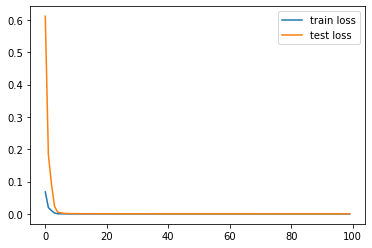

epoch:  0
train loss:  0.07713945976951543
test loss:  0.6991943120956421
epoch:  1
train loss:  0.023038667133625818
test loss:  0.20992419868707657
epoch:  2
train loss:  0.010988434338394333
test loss:  0.10045758844353259
epoch:  3
train loss:  0.0032401736209388167
test loss:  0.028518372972030193
epoch:  4
train loss:  0.000609793234616518
test loss:  0.00551427407481242
epoch:  5
train loss:  0.0003398612076553571
test loss:  0.0031744853913551196
epoch:  6
train loss:  0.0002558909310370355
test loss:  0.002375023832428269
epoch:  7
train loss:  0.0001890293591286001
test loss:  0.0017596247635083273
epoch:  8
train loss:  0.00015023352042429477
test loss:  0.0014234619702619966
epoch:  9
train loss:  0.0001298948661903577
test loss:  0.0012521191601990722
epoch:  10
train loss:  0.0001170665431452696
test loss:  0.0011019473895430565
epoch:  11
train loss:  0.00010631067989914514
test loss:  0.0009960680217773188
epoch:  12
train loss:  9.474865381729186e-05
test loss:  0.0008

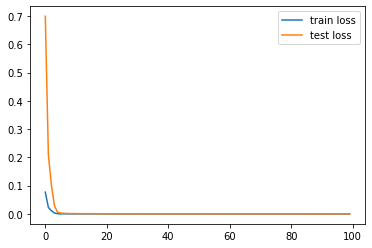

epoch:  0
train loss:  0.06665441218544454
test loss:  0.6048635821789503
epoch:  1
train loss:  0.01886573905015693
test loss:  0.17147453501820564
epoch:  2
train loss:  0.00895511660286609
test loss:  0.07955485372804105
epoch:  3
train loss:  0.003201362060602097
test loss:  0.028319148055743426
epoch:  4
train loss:  0.0010550821230828982
test loss:  0.009402017589309253
epoch:  5
train loss:  0.00042079449357355344
test loss:  0.003782909880101215
epoch:  6
train loss:  0.00026796743794180015
test loss:  0.0024751329692662694
epoch:  7
train loss:  0.00021258369516170418
test loss:  0.0019796887863776647
epoch:  8
train loss:  0.00018718047752319013
test loss:  0.001743901229929179
epoch:  9
train loss:  0.00015437453497297074
test loss:  0.0014432977550313808
epoch:  10
train loss:  0.00012936707207700238
test loss:  0.0012029112622258253
epoch:  11
train loss:  0.00012266414448865414
test loss:  0.0011287098459433764
epoch:  12
train loss:  0.00010320670074125861
test loss:  0.

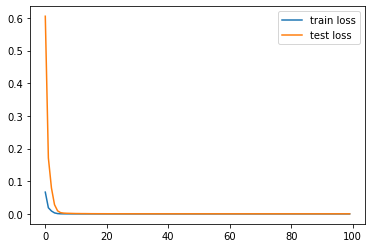

epoch:  0
train loss:  0.08603447237435509
test loss:  0.7746289260685444
epoch:  1
train loss:  0.026141477584400597
test loss:  0.23691341606900096
epoch:  2
train loss:  0.013679087216801503
test loss:  0.12684537004679441
epoch:  3
train loss:  0.005851469331366175
test loss:  0.05228386097587645
epoch:  4
train loss:  0.0015307543456883116
test loss:  0.013990897103212774
epoch:  5
train loss:  0.0010061438387150273
test loss:  0.009274143143557012
epoch:  6
train loss:  0.0005843334536835113
test loss:  0.00535923607822042
epoch:  7
train loss:  0.0003571880960782223
test loss:  0.0033542165474500507
epoch:  8
train loss:  0.00028714607298538526
test loss:  0.002760231465799734
epoch:  9
train loss:  0.00023143570647602354
test loss:  0.002157198527129367
epoch:  10
train loss:  0.0001754885512020658
test loss:  0.0016633707346045412
epoch:  11
train loss:  0.00014162453076363925
test loss:  0.00134034580696607
epoch:  12
train loss:  0.00012839328701375052
test loss:  0.00121192

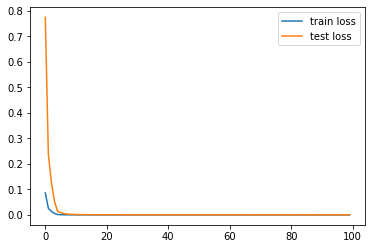

<Figure size 432x288 with 0 Axes>

In [6]:
# train #
avg_train_loss = []
avg_test_loss = []
for seed in range(5):
    model = NN().to(DEVICE)
    optimizer = optim.Adam(
                        model.parameters(),
                        lr=0.001,
                        weight_decay=0.0005)
    criterion = nn.MSELoss().to(DEVICE)
    X = df_long.drop(columns = ["seed", "fitness"]).to_numpy(dtype="float32")
    y = df_long["fitness"].to_numpy(dtype="float32")
    y/=100
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=seed)
    train_data =  Data(X_train, y_train)
    test_data =  Data(X_test, y_test)
    train_loader = DataLoader(train_data, batch_size=BATCHSIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCHSIZE, shuffle=False)
    train_losses = []
    test_losses = []
    for epoch in range(EPOCHS):
        running_loss = 0.0
        correct = 0
        total = 0
        for X, y in train_loader:
            inputs, labels = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            # record predictions
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        # compute acc
        train_loss = running_loss / len(train_loader)
        # record loss
        train_losses.append(train_loss)
        print("epoch: ", epoch)
        print("train loss: ", train_loss)

        with torch.no_grad():
            for X, y in test_loader:
                inputs, labels = X.to(DEVICE), y.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            test_loss = running_loss / len(test_loader)
        test_losses.append(test_loss)
        print("test loss: ", test_loss)
    plt.plot(train_losses, label="train loss")
    plt.plot(test_losses, label="test loss")
    plt.legend()
    plt.show()
    plt.clf()
    avg_train_loss.append(sum(train_losses)/len(train_losses))
    avg_test_loss.append(sum(test_losses)/len(test_losses))


In [7]:
data = [[loss, "train"] for loss in avg_train_loss] + [[loss, "test"] for loss in avg_test_loss]
df = pd.DataFrame(data, columns=["loss", "split"])
df

,loss,split
0,0.001682,train
1,0.001065,train
2,0.001202,train
3,0.001041,train
4,0.001402,train
5,0.015315,test
6,0.009642,test
7,0.010922,test
8,0.009440,test
9,0.012695,test


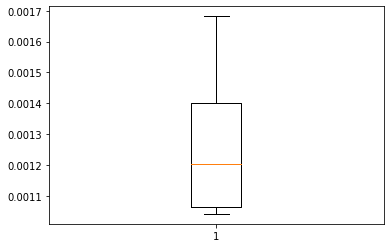

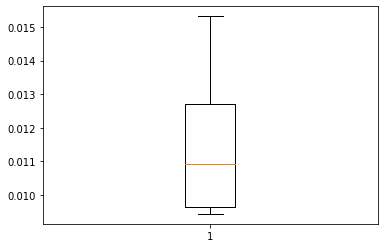

<Figure size 432x288 with 0 Axes>

In [8]:
# sns.boxplot(df, x="split", y="loss")
plt.boxplot(avg_train_loss)
plt.show()
plt.clf()
plt.boxplot(avg_test_loss)
plt.show()
plt.clf()

In [16]:
df_long

,TranslateX,ShearY,Color,Sharpness,TranslateY,Brightness,Rotate,VerticalFlip,HorizontalFlip,Solarize,Contrast,ShearX,seed,fitness
0,0.0,0.000000,0.502598,0.0,0.0,0.690515,0.0,0.000000,0.0,0.000000,0.000000,0.071512,1.0,84.01
1,0.0,0.009524,0.000000,0.0,0.0,0.690515,0.0,0.000000,0.0,0.969784,0.000000,0.000000,1.0,83.05
2,8.0,0.185176,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.763682,0.000000,1.0,81.59
3,0.0,0.000000,0.594466,0.0,0.0,0.000000,13.0,0.080950,0.0,0.000000,0.000000,0.000000,1.0,83.94
4,11.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.569917,0.0,0.000000,0.000000,0.136720,1.0,83.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,10.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.182348,0.002278,3.0,82.47
596,0.0,0.000000,0.000000,0.0,2.0,0.000000,0.0,0.164938,0.0,0.000000,0.000000,0.002278,3.0,82.18
597,9.0,0.000000,0.000000,0.0,2.0,0.000000,0.0,0.000000,0.0,0.969784,0.000000,0.000000,3.0,82.47
598,0.0,0.185176,0.594466,0.0,0.0,0.000000,13.0,0.000000,0.0,0.000000,0.000000,0.000000,3.0,83.67


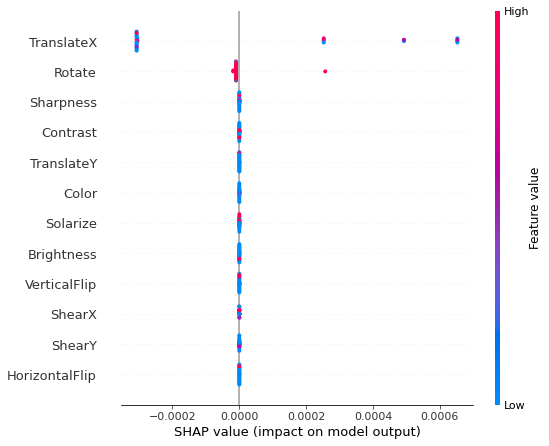

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
train_data =  Data(X_train, y_train)
test_data =  Data(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
data_fit, _ = next(iter(train_loader))

e = DeepExplainer(model, data_fit.to(DEVICE))
data_eval, _ = next(iter(train_loader))
shap_values = e.shap_values(data_eval.to(DEVICE))
shap.summary_plot(shap_values, data_fit, feature_names=list(ops))
